In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

# Nested Diagrams

In [ ]:
from stringdale.diagrams import (
    Define,
    V,
    E,
)
from stringdale.std import Condition

In [ ]:
def add(a,b):
    return a+b

class Pow():
    def __init__(self,power):
        self.power = power
    def __call__(self,a):
        return a**self.power
    def __str__(self):
        return f'Pow({self.power})'

is_even = lambda x: x%2==0

To allow compositionality, a node can take a Diagram Schema object instead of a function.
Here is an example:

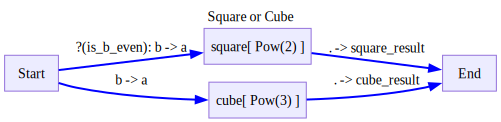

In [ ]:
with Define('Square or Cube',type='decision',direction='LR') as SquareOrCube:
    V('square',Pow(2),inputs=[
        ('Start(a=b)',Condition(is_even,mapping='x=b',name='is_b_even')),
        ],
        outputs=['End(square_result=.)'])
    V('cube',Pow(3),inputs=['Start(a=b)'],outputs=['End(cube_result=.)'])

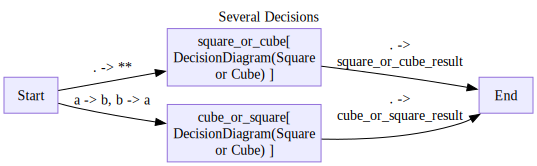

In [ ]:
with Define('Several Decisions',type='flow',direction='LR') as SeveralDecisions:
    V('square_or_cube',SquareOrCube,inputs=['Start(**)'],outputs=['End(square_or_cube_result=.)'])
    V('cube_or_square',SquareOrCube,inputs=['Start(b=a,a=b)'],outputs=['End(cube_or_square_result=.)'])
    

In [ ]:
d=SeveralDecisions()
for trace in d.run({'a':3,'b':2}):
    trace.pprint(skip_passthrough=True)

d.output

Node cube_or_square.cube:
{'input': {'a': 3}, 'output': 27}
Node square_or_cube.square:
{'input': {'a': 2}, 'output': 4}
Node cube_or_square:
{'input': {'a': 2, 'b': 3}, 'output': {'cube_result': 27}}
Node square_or_cube:
{'input': {'a': 3, 'b': 2}, 'output': {'square_result': 4}}


{'cube_or_square_result': {'cube_result': 27},
 'square_or_cube_result': {'square_result': 4}}

Note that traces of subdiagrams are also returned to you when running the main diagram.
Their trace are namespaced with the name of the node that the subdiagram resides in.

All diagram types can be nested in all diagram types as deep as you want you can even react to breakpoints inside sub diagrams:

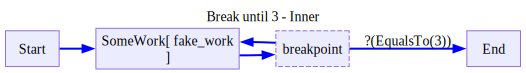

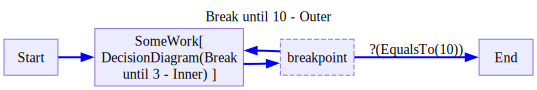

In [ ]:
class EqualsTo:
    def __init__(self,value):
        self.value = value
    def __call__(self,x):
        return x==self.value
    def __str__(self):
        return f'EqualsTo({self.value})'

def fake_work(x):
    return x

with Define('Break until 3 - Inner',type='decision',direction='LR') as InnerBreak:
    V('SomeWork',fake_work,inputs=['Start'],
    outputs=['breakpoint']
    )
    V('breakpoint',is_break=True,outputs=[
        'SomeWork',
        ('End',EqualsTo(3)),
        ])


with Define('Break until 10 - Outer',type='decision',direction='LR') as OuterBreak:
    V('SomeWork',InnerBreak,inputs=['Start'],
        outputs=['breakpoint']
    )
    V('breakpoint',is_break=True,outputs=[
        'SomeWork',
        ('End',EqualsTo(10)),
        ])
    

In [ ]:
d = OuterBreak()

inputs = [
    0, # will stay in subdiagram until 3
    1,
    2, 
    3, # will exit subdiagram
    5, # enter subdiagram again
    10, # stay in subdiagram since its waiting for 3
    3, # will exit subdiagram
    10, # will exit diagram
    100 # will not be touched
]


while True:
    input = inputs.pop(0)
    for trace in d.run(input):
        # trace.pprint()
        pass
    if d.finished:
        break
inputs,d.output

([100], 10)

There is only one caveat:

* Decision diagrams with breakpoints, cant be nested inside flow diagrams.

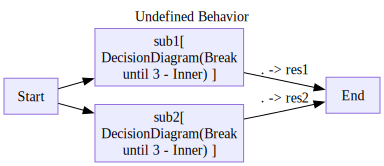

<ExceptionInfo ValueError('Breakpoints are not allowed in a Flow diagram (Undefined Behavior)') tblen=8>

In [ ]:
import pytest
with pytest.raises(ValueError) as exeinfo:
    with Define('Undefined Behavior',direction='LR') as Schema:
        V('sub1',InnerBreak,inputs=['Start'],outputs=['End(res1=.)'])
        V('sub2',InnerBreak,inputs=['Start'],outputs=['End(res2=.)'])
exeinfo